# Shapelet Based Classication

Import Required Libraries 

In [32]:
import collections
import itertools
import operator
import pickle
import random
import threading
import time
from time import sleep
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import progressbar
import seaborn as sns
from saxpy.sax import sax_via_window
from scipy.io import arff
from scipy.spatial import distance
from sklearn import tree
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, normalize
from sklearn.utils.validation import check_array, check_is_fitted, check_X_y

%matplotlib inline
INPUT_DIR = "./Datasets/"


# Function to plot bar graph
def plot_graph(Dictionary, mytitle, ytitle="Accuracy", prune=False):
    ys = sorted(Dictionary.values(), reverse=True)
    labels = sorted(Dictionary, key=Dictionary.get, reverse=True)
    xs = np.arange(len(labels))
    # Set title
    plt.figure(figsize=(15, 7))
    plt.title(mytitle, fontsize=15)
    plt.bar(xs, ys, align='center', color=getColors(len(xs)), tick_label=ys)
    plt.xticks(
        xs,
        labels)  #Replace default x-ticks with xs, then replace xs with labels
    plt.xlabel("Classifier Type")
    plt.yticks(ys)
    plt.ylabel(ytitle)
    plt.xticks(rotation=90)
    plt.tick_params(axis='y', which='major')
    # To ensure differences are scene start y value close to first value
    plt.ylim(bottom=ys[-1] - 0.01)
    # Prune y axis to avoid overlap
    if prune:
        new_y = []
        for i, y in enumerate(ys):
            if i == 0:
                prev = y
                new_y.append(prev)
                continue
            if (prev - y > 0.005):
                new_y.append(y)
            prev = y
        plt.yticks(new_y)
    plt.show()

In [79]:
class ShapeletClassifier(BaseEstimator, ClassifierMixin):
    def fetchDistanceMeasure(self, dist_fn):
        # Map in the function of the distance metric
        if dist_fn == 'euclidean':
            return euclidean_distances
        elif dist_fn == 'manhattan':
            return manhattan_distances
        elif dist_fn == 'cosine':
            return distance.cosine
        else:
            return distance.euclidean

    def __init__(self,
                 min_len=20,
                 max_len=20,
                 n_threads=5,
                 shapelet_count=10,
                 dist_fn='euclidean',
                 prune_shapelets=False,
                 similarity_threshold=1,
                 infreq_support = 5,
                 infreq_shapelets=False,
                 normalize=True,
                 verbose=False,
                 logical_shapelets=False,
                 logical_operators=['and', 'or'],
                 logical_limit=2,
                 lfdps=False,
                 classifiers=['dtree','knn'],
                 classifier_arg={'k': 3},
                 fast_shapelet_arg={
                     'n_masking': 2,
                     'mask_len': 2,
                     'alpha_size': 5
                 },
                 fast_shapelets=False):
        self.min_len = min_len
        self.max_len = max_len
        self.n_threads = n_threads
        self.normalize = normalize
        self.dist_fn = self.fetchDistanceMeasure(dist_fn)
        self.shapelet_count = shapelet_count
        self.shapelet_dict = {}
        self.shapelet_dict_new = {}
        self.thread_count = 0
        self.shapelet_dict1 = {}
        self.prune_shapelets = prune_shapelets
        self.similarity_threshold = similarity_threshold
        self.infreq_support = infreq_support
        self.infreq_shapelets = infreq_shapelets
        self.verbose = verbose
        self.fast_shapelet_arg = fast_shapelet_arg
        self.fast_shapelets = fast_shapelets
        self.logical_shapelets = logical_shapelets
        self.logical_limit = logical_limit
        self.lfdps = lfdps
        self.logical_operators = logical_operators
        self.classifiers = classifiers
        self.classifier_arg = classifier_arg
        self.dtree_clf = tree.DecisionTreeClassifier()
        self.knn_clf = KNeighborsClassifier(n_neighbors=self.classifier_arg['k'])

    def save_model(self, pickle_dir="shapelet.pickle"):
        pickle_out = open(pickle_dir, "wb")
        pickle.dump(self.shapelet_dict1, pickle_out)
        pickle_out.close()

    def load_model(self, pickle_dir="shapelet.pickle"):
        pickle_in = open(pickle_dir, "rb")
        self.shapelet_dict1 = pickle.load(pickle_in)
        return self.shapelet_dict1

    def window(seq, n=10):
        "Returns a sliding window (of width n) over data from the iterable"
        "   s -> (s0,s1,...s[n-1]), (s1,s2,...,sn), ...                   "
        it = iter(seq)
        result = tuple(islice(it, n))
        if len(result) == n:
            yield result
        for elem in it:
            result = result[1:] + (elem, )
            yield result

    # Generate Subsequence candidates
    def generate_candidates(self):
        candidates, cand_len = [], self.max_len
        # Fast shapelets (SAX Representation)
        if self.fast_shapelets:
            while cand_len >= self.min_len:
                sax_time_series = []
                mask_patterns = []
                mask_dict = []
                sax_list = []
                masked_words = {}
                sax_index = []
                sax_counts = []
                max_count = 0
                if (self.fast_shapelet_arg['n_masking'] <
                        self.fast_shapelet_arg['alpha_size']):
                    counter = 0
                    while counter < self.fast_shapelet_arg['n_masking']:
                        mask_index = random.sample(
                            range(self.fast_shapelet_arg['alpha_size']),
                            self.fast_shapelet_arg['mask_len'])
                        if mask_index in mask_patterns:
                            continue
                        mask_patterns.append(mask_index)
                        counter += 1
                counter = 0
                for time_serie, label in zip(self.time_series, self.labels):
                    sax = sax_via_window(time_serie, cand_len, 5, 5, "none",
                                         0.01)
                    sax_ = {}
                    for key, indexes in sax.items():
                        for index in indexes:
                            sax_[index] = key
                    sax = list(sax_.values())
                    sax_time_series.append((sax, label))
                    sax_list.extend(sax)
                for iteration in mask_patterns:
                    masked_list = {}
                    masked_words = []
                    for sax_series, label in sax_time_series:
                        masked_sax = []
                        words = sax_series
                        for mask_index in iteration:
                            if mask_index == 0:
                                words = [word[1:] for word in words]
                            elif mask_index == self.fast_shapelet_arg[
                                    'alpha_size'] - 1:
                                words = [
                                    word[:self.
                                         fast_shapelet_arg['alpha_size'] - 1]
                                    for word in words
                                ]
                            else:
                                words = [
                                    (word[:mask_index] + word[mask_index + 1:])
                                    for word in words
                                ]
                        masked_words.extend(words)
                        if label in masked_list:
                            masked_list[label] = masked_list[label] + words
                        else:
                            masked_list[label] = words
                    if not sax_counts:
                        for word in masked_words:
                            sax_dict = {}
                            for label in masked_list:
                                sax_dict[label] = masked_list[label].count(
                                    word)
                                max_count = max(max_count, sax_dict[label])
                            sax_counts.append(sax_dict)
                    else:
                        for index, word in enumerate(masked_words):
                            sax_dict = sax_counts[index]
                            for label in masked_list:
                                sax_dict[label] = sax_dict[
                                    label] + masked_list[label].count(word)
                                max_count = max(max_count, sax_dict[label])
                            sax_counts[index] = sax_dict
                            sax_complement = []
                            sax_dist_pow = []
                            for sax_count in sax_counts:
                                sax_dict = {}
                                sax_dist = {}
                                for label in sax_count:
                                    sax_dict[
                                        label] = max_count - sax_count[label]
                                sax_dist = {
                                    key: sax_dict[key] - sax_count.get(key, 0)
                                    for key in sax_count.keys()
                                }
                                sax_complement.append(sax_dict)
                                sax_dist_pow.append(sum(sax_dist.values()))
                        max_dist_pow = sorted(
                            range(len(sax_dist_pow)),
                            key=lambda i: sax_dist_pow[i],
                            reverse=True)[:self.shapelet_count]
                        for max_index in max_dist_pow:
                            index = 0
                            for idx, time_serie in enumerate(sax_time_series):
                                index += len(time_serie[0])
                                if index >= max_index:
                                    location = max_index - (index -
                                                            len(time_serie[0]))
                                    candidates.append(
                                        (self.time_series[idx]
                                         [location:location + cand_len],
                                         time_serie[1]))
                                    break
                cand_len -= 1
        # Normal representation
        else:
            while cand_len >= self.min_len:
                for time_serie, label in zip(self.time_series, self.labels):
                    for k in range(len(time_serie) - cand_len + 1):
                        candidates.append((time_serie[k:k + cand_len], label))
                cand_len -= 1
        return pd.DataFrame(candidates)

    # Fit & Train the dataset
    def fit(self, X, y):
        # Local variables
        feature_set = list([])
        feature_columns = []
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Normalize
        if self.normalize:
            self.time_series = X
        else:
            self.time_series = normalize(X)
        # Convert to LFDPs
        if self.lfdps:
            lfdp = []
            for time_serie in self.time_series:
                time_serie = self.convert_to_lfdp(time_serie)
                lfdp.append(time_serie)
            self.time_series = lfdp
        # Fetch labels
        self.classes = np.unique([label for label in y])
        # Find discriminative shapelets for each label
        for _class in self.classes:
            labels = []
            self.shapelet_dict_new = {}
            self.shapelet_dict = {}
            print(" Fetching Shapelets to represent the target class:", _class)
            if self.verbose:
                self.bar = progressbar.ProgressBar(
                    maxval=self.n_threads,
                    widgets=[
                        progressbar.Bar('=', '[', ']'), ' ',
                        progressbar.Percentage()
                    ])
                self.thread_count = 0
            # Assign one vs all categorization for the current label
            for label in y:
                if label == _class: labels.append(1)
                else: labels.append(0)
            # Store labels for multi-threading
            self.labels = pd.Series(labels)
            # Generate Candidates
            candidates = self.generate_candidates()                
            # Reduce candidates based on frequency
            if self.infreq_shapelets:
                candidates = self.infrequent_candidates(candidates)
            # Pruning Algorithm Based on Similiarity
            if self.prune_shapelets:
                candidates = self.prune_candidates(candidates)
            # Split candidates into batches
            split_candidates = np.array_split(candidates, self.n_threads)
            # Create threads for each batch
            threads = [
                threading.Thread(target=self.find_best_shapelet_worker,
                                 args=[
                                     pd.DataFrame(split_candidate),
                                 ]) for split_candidate in split_candidates
            ]
            # Find total thread count
            self.thread_total = len(threads)
            # Start bar visualisation
            if self.verbose:
                self.bar.start()

            # Start finding shapelets
            for thread in threads:
                thread.start()
            for thread in threads:
                thread.join()
            if self.verbose:
                self.bar.finish()

            #  Return top k shapelets
            if self.logical_shapelets:
                if self.verbose:
                    print("Fetch Logical Shapelets")
                self.shapelet_dict = {
                    key: self.shapelet_dict[key]
                    for key in sorted(self.shapelet_dict.keys(), reverse=True)
                    [:self.shapelet_count]
                }
                self.shapelet_dict_new = dict(self.shapelet_dict)
                # Create threads for each batch
                threads = [
                    threading.Thread(target=self.logical_shapelet,
                                     args=[
                                         operator,
                                     ]) for operator in self.logical_operators
                ]
                
                if self.verbose:
                    self.log_bar = progressbar.ProgressBar(
                        maxval=len(self.logical_operators*len(self.shapelet_dict.keys())),
                        widgets=[
                            progressbar.Bar('=', '[', ']'), ' ',
                            progressbar.Percentage()
                        ])
                    self.log_bar.start()
                    self.thread_count=0
                # Start finding shapelets
                for thread in threads:
                    thread.start()
                for thread in threads:
                    thread.join()
                if self.verbose:
                    self.log_bar.finish()
                self.shapelet_dict = dict(self.shapelet_dict_new)                
            # Sort and save shapelets for class
            self.shapelet_dict1[_class] = {
                key: self.shapelet_dict[key]
                for key in sorted(self.shapelet_dict.keys(), reverse=True)
                [:self.shapelet_count]
            }
        if self.logical_shapelets:
            # Create feature matrix
            for x, label in zip(X, y):
                temp_df = []
                feature_column = 0
                for _class in self.shapelet_dict1:
                    shapelet_dict = self.shapelet_dict1[_class]
                    for ig in shapelet_dict:
                        if shapelet_dict[ig][0] == 'single':
                            dist, split_idx = self.subsequence_distance(x, shapelet_dict[ig][1])
                        elif shapelet_dict[ig][0] == 'and':
                            for idx,shapelet in enumerate(shapelet_dict[ig][1]):
                                temp_dist, split_idx = self.subsequence_distance(x, shapelet)
                                if idx == 0:
                                    dist = temp_dist
                                elif temp_dist > dist:
                                    dist = temp_dist
                        else:
                            for idx,shapelet in enumerate(shapelet_dict[ig][1]):
                                temp_dist, split_idx = self.subsequence_distance(x, shapelet)
                                if idx == 0:
                                    dist = temp_dist
                                elif temp_dist < dist:
                                    dist = temp_dist
                        temp_df.append(dist)
                        if feature_column not in feature_columns:
                            feature_columns.append(feature_column)
                        feature_column += 1
                temp_df.append(label)
                feature_set.append(temp_df)
            feature_columns.append('label')
        else:
            # Create feature matrix
            for x, label in zip(X, y):
                temp_df = []
                feature_column = 0
                for _class in self.shapelet_dict1:
                    shapelet_dict = self.shapelet_dict1[_class]
                    for ig in shapelet_dict:
                        dist, split_idx = self.subsequence_distance(
                            x, shapelet_dict[ig][0])
                        temp_df.append(dist)
                        if feature_column not in feature_columns:
                            feature_columns.append(feature_column)
                        feature_column += 1
                temp_df.append(label)
                feature_set.append(temp_df)
            feature_columns.append('label')
        # Feature set based on shapelet distance
        self.feature_set = pd.DataFrame(feature_set, columns=feature_columns)
        # Train Classifiers
        # 1. Decision Tree
        if 'dtree' in self.classifiers:
            trainX, trainY = self.feature_set[self.feature_set.columns[:-1]].values, self.feature_set['label'].values
            self.dtree_clf = self.dtree_clf.fit(trainX, trainY)
        # 2. K-nearest neighbours
        if 'knn' in self.classifiers:
            trainX, trainY = self.feature_set[self.feature_set.columns[:-1]].values, self.feature_set['label'].values
            self.knn_clf = self.knn_clf.fit(trainX, trainY)
        return self

    def logical_shapelet(self, operator):
        for ig in self.shapelet_dict:
            shapelet_array = [self.shapelet_dict[ig][1]]
            logical_count = 1
            for temp_ig in self.shapelet_dict:
                if ig == temp_ig:
                    continue
                shapelet_array.append(self.shapelet_dict[temp_ig][1])
                gain, dist, left, right, gap = self.check_logical_candidate(
                    shapelet_array, logical_operator=operator)
                logical_count += 1
                if logical_count > self.logical_limit:
                    break
                if gain > ig and gain not in self.shapelet_dict_new:
                    self.shapelet_dict_new[gain] = [
                        operator, shapelet_array, dist, gap
                    ]
                elif gain > ig and gain in self.shapelet_dict_new and self.shapelet_dict_new[
                        gain][3] < gap:
                    self.shapelet_dict_new[gain] = [
                        operator, shapelet_array, dist, gap
                    ]
            if self.verbose:
                self.thread_count += 1
                self.log_bar.update(self.thread_count)

    def visualise_shapelets(self, n=10):
        for _class in self.classes:
            count = 0
            print("FOR CLASS ", _class)
            shapelet_dict = self.shapelet_dict1[_class]
            if self.logical_shapelets:
                for ig in shapelet_dict:
                    print("Information Gain:", ig)
                    print("Operation:", shapelet_dict[ig][0])
                    print("Distance:", shapelet_dict[ig][2])
                    if shapelet_dict[ig][0] == 'single':
                        plt.plot(shapelet_dict[ig][1])
                        count += 1
                    else:
                        if count < n:
                            for shapelets in shapelet_dict[ig][1]:
                                print(shapelets)
                                plt.plot(shapelets)
                                count += 1
                                if count == n: break
                    plt.show()
                    if count == n: break
            else:
                for ig in shapelet_dict:
                    print("Information Gain:", ig)
                    print("Distance:", shapelet_dict[ig][1])
                    plt.plot(shapelet_dict[ig][0])
                    plt.show()
                    count += 1
                    if count == n: break
                        

            

    def predict(self, X, k=1, classifier="knn"):

        # Fetch labels of time series
        self.classes = list(self.shapelet_dict1.keys())
        # Check is fit had been called
        check_is_fitted(self, ['shapelet_dict1'])
        # Input validation
        X = check_array(X)
#         # Convert to LFDPs
#         if self.lfdps:
#             lfdp = []
#             for time_serie in X:
#                 time_serie = self.convert_to_lfdp(time_serie)
#                 lfdp.append(time_serie)
#             X = lfdp
        # Output
        y = list()
        if self.normalize:
            self.time_series = X
        else:
            self.time_series = normalize(X)
        if self.logical_shapelets:
            # Map in the function of the distance metric
            if classifier == 'd_tree':
                for x in X:
                    neighbours = {}
                    i = 0
                    votes = {}
                    no_shapelets = len(self.classes) - 2
                    for idx, _class in enumerate(self.classes):
                        shapelet_dict = self.shapelet_dict1[_class]
                        found = False
                        for ig in shapelet_dict:
                            logical_combo = False
                            if found:
                                break
                            if shapelet_dict[ig][0] == 'single':
                                dist, split_idx = self.subsequence_distance(
                                    x, shapelet_dict[ig][1])
                                if (dist < shapelet_dict[ig][2]):
                                    logical_combo = True
                            else:
                                for shapelet in shapelet_dict[ig][1]:
                                    dist, split_idx = self.subsequence_distance(
                                        x, shapelet)
                                    if (dist < shapelet_dict[ig][2]
                                            and shapelet_dict[ig][0] == 'and'):
                                        logical_combo = True
                                    elif (dist < shapelet_dict[ig][2]
                                          and shapelet_dict[ig][0] == 'or'):
                                        logical_combo = True
                                        break
                                    else:
                                        logical_combo = False
                                        break
                            if logical_combo == True:
                                y.append(_class)
                                found = True
                            elif (idx == no_shapelets):
                                y.append(self.classes[idx + 1])
                                found = True
                            break
                        if (found):
                            break
            # K nearest neighbour
            elif classifier == 'knn':
                feature_columns = []
                feature_set = list([])
                for x in X:
                    temp_df = []
                    feature_column = 0
                    for _class in self.shapelet_dict1:
                        shapelet_dict = self.shapelet_dict1[_class]
                        for ig in shapelet_dict:
                            if shapelet_dict[ig][0] == 'single':
                                dist, split_idx = self.subsequence_distance(
                                    x, shapelet_dict[ig][1])
                            elif shapelet_dict[ig][0] == 'and':
                                for idx,shapelet in enumerate(shapelet_dict[ig][1]):
                                    temp_dist, split_idx = self.subsequence_distance(x, shapelet)
                                    if idx == 0:
                                        dist = temp_dist
                                    elif temp_dist > dist:
                                        dist = temp_dist
                            else:
                                for idx,shapelet in enumerate(shapelet_dict[ig][1]):
                                    temp_dist, split_idx = self.subsequence_distance(x, shapelet)
                                    if idx == 0:
                                        dist = temp_dist
                                    elif temp_dist < dist:
                                        dist = temp_dist
                            temp_df.append(dist)
                            if feature_column not in feature_columns:
                                feature_columns.append(feature_column)
                                feature_column += 1
                    feature_set.append(temp_df)
                return self.knn_clf.predict(feature_set)
            # Decision Tree
            elif classifier == 'dtree':
                feature_columns = []
                feature_set = list([])
                for x in X:
                    temp_df = []
                    feature_column = 0
                    for _class in self.shapelet_dict1:
                        shapelet_dict = self.shapelet_dict1[_class]
                        for ig in shapelet_dict:
                            if shapelet_dict[ig][0] == 'single':
                                dist, split_idx = self.subsequence_distance(
                                    x, shapelet_dict[ig][1])
                            elif shapelet_dict[ig][0] == 'and':
                                for idx,shapelet in enumerate(shapelet_dict[ig][1]):
                                    temp_dist, split_idx = self.subsequence_distance(x, shapelet)
                                    if idx == 0:
                                        dist = temp_dist
                                    elif temp_dist > dist:
                                        dist = temp_dist
                            else:
                                for idx,shapelet in enumerate(shapelet_dict[ig][1]):
                                    temp_dist, split_idx = self.subsequence_distance(x, shapelet)
                                    if idx == 0:
                                        dist = temp_dist
                                    elif temp_dist < dist:
                                        dist = temp_dist
                            temp_df.append(dist)
                            if feature_column not in feature_columns:
                                feature_columns.append(feature_column)
                                feature_column += 1
                    feature_set.append(temp_df)
                return self.dtree_clf.predict(feature_set)
        else:
            # Map in the function of the distance metric
            if classifier == 'd_tree':
                for x in X:
                    neighbours = {}
                    i = 0
                    votes = {}
                    no_shapelets = len(self.classes) - 2
                    for idx, _class in enumerate(self.classes):
                        shapelet_dict = self.shapelet_dict1[_class]
                        found = False
                        for ig in shapelet_dict:
                            if found:
                                break
                            dist, split_idx = self.subsequence_distance(
                                x, shapelet_dict[ig][0])
                            if (dist < shapelet_dict[ig][1]):
                                y.append(_class)
                                found = True
                            elif (idx == no_shapelets):
                                y.append(self.classes[idx + 1])
                                found = True
                            break
                        if (found):
                            break
            # K nearest neighbour
            elif classifier == 'knn':
                feature_columns = []
                feature_set = list([])
                for x in X:
                    temp_df = []
                    feature_column = 0
                    for _class in self.shapelet_dict1:
                        shapelet_dict = self.shapelet_dict1[_class]
                        for ig in shapelet_dict:
                            dist, split_idx = self.subsequence_distance(
                                x, shapelet_dict[ig][0])
                            temp_df.append(dist)
                            if feature_column not in feature_columns:
                                feature_columns.append(feature_column)
                                feature_column += 1
                    feature_set.append(temp_df)
                return self.knn_clf.predict(feature_set)
            # Decision Tree
            elif classifier == 'dtree':
                feature_columns = []
                feature_set = list([])
                for x in X:
                    temp_df = []
                    feature_column = 0
                    for _class in self.shapelet_dict1:
                        shapelet_dict = self.shapelet_dict1[_class]
                        for ig in shapelet_dict:
                            dist, split_idx = self.subsequence_distance(
                                x, shapelet_dict[ig][0])
                            temp_df.append(dist)
                            if feature_column not in feature_columns:
                                feature_columns.append(feature_column)
                                feature_column += 1
                    feature_set.append(temp_df)
                return self.dtree_clf.predict(feature_set)
            # knn
            else:
                for x in X:
                    neighbours = {}
                    i = 0
                    found_k_nn = False
                    votes = {}
                    for _class in self.classes:
                        shapelet_dict = self.shapelet_dict1[_class]
                        for ig in shapelet_dict:
                            dist, idx = self.subsequence_distance(
                                x, shapelet_dict[ig][0])
                            if dist not in neighbours:
                                neighbours[dist] = [_class]
                            else:
                                dist_values = neighbours[dist]
                                dist_values.append(_class)
                                neighbours[dist] = dist_values
                    for neighbour in sorted(neighbours):
                        for _class in neighbours[neighbour]:
                            if _class not in votes:
                                votes[_class] = 1
                            else:
                                votes[_class] += 1
                            i += 1
                            if i > self.classifier_arg['k']:
                                found_k_nn = True
                                break
                        if found_k_nn == True:
                            y.append(
                                max(votes.items(),
                                    key=operator.itemgetter(1))[0])
                            break
        return np.array(y)

    def prune_candidates(self,  candidates):
        pruned_candidates = []
        distan = []
        for idx, candidate in candidates.iterrows():
            add = True
            for idx_dup, candidate_dup in candidates.iterrows():
                if idx_dup < idx and len(candidate[0]) == len(
                        candidate_dup[0]):
                    dist = np.sum(
                        self.dist_fn([candidate[0], candidate_dup[0]]))
                    if dist < self.similarity_threshold:
                        add = False
                        break
            if add:
                pruned_candidates.append(candidate)
        return pd.DataFrame(pruned_candidates)
    
    def infrequent_candidates(self,  candidates):
        infrequent_candidates = []
        candidate_freq = dict()
        for idx, candidate in candidates.iterrows():
            candidate_freq[idx]=0
            for idx_dup, candidate_dup in candidates.iterrows():
                if idx_dup != idx and len(candidate[0]) == len(
                        candidate_dup[0]):
                    dist = np.sum(
                        self.dist_fn([candidate[0], candidate_dup[0]]))
                    if dist < self.similarity_threshold:
                        candidate_freq[idx] += 1
        infreq_candidates = [candidates.iloc[idx] for (idx,count) in candidate_freq.items() if candidate_freq[idx] <= (self.infreq_support * len(candidates.index))]
        return pd.DataFrame(infreq_candidates)

    def manhattan_distance(self, x, y, min_dist=float('inf')):
        dist = np.sum(self.dist_fn([x, y]))
        if dist >= min_dist:
            return None
        return dist

    def subsequence_distance(self, time_serie, sub_seq):
        if len(sub_seq) < len(time_serie):
            min_dist, min_idx = float("inf"), 0
            for i in range(len(time_serie) - len(sub_seq) + 1):
                dist = self.manhattan_distance(sub_seq,
                                               time_serie[i:i + len(sub_seq)],
                                               min_dist)
                if dist is not None and dist < min_dist:
                    min_dist, min_idx = dist, i
            return min_dist, min_idx
        else:
            return 0,0

    def calculate_entropy(self, probabilities):
        return sum([
            -prob * np.log(prob) / np.log(2) if prob != 0 else 0
            for prob in probabilities
        ])

    def calculate_dict_entropy(self, distances):
        count = {}
        for distance in distances:
            if distance[1] in count:
                count[distance[1]] += 1
            else:
                count[distance[1]] = 1
        return self.calculate_entropy(
            np.divide(list(count.values()), float(sum(list(count.values())))))

    def check_candidate(self, shapelet):
        distances = {}
        for time_serie, label in zip(self.time_series, self.labels):
            dist, idx = self.subsequence_distance(time_serie, shapelet)
            if dist is not None:
                if dist not in distances:
                    distances[dist] = [(time_serie, label)]
                else:
                    distances[dist].append((time_serie, label))
        ordered_dict = collections.OrderedDict(sorted(distances.items()))
        return self.find_best_split_dist(ordered_dict)

    def check_logical_candidate(self, shapelets, logical_operator='and'):
        distances = {}
        for time_serie, label in zip(self.time_series, self.labels):
            dist, idx = 0, 0
            temp_dist, temp_idx = 0,0
            for index, shapelet in enumerate(shapelets):
                temp_dist, temp_idx = self.subsequence_distance(
                    time_serie, shapelet)
                if index == 0:
                    dist = temp_dist
                    idx = temp_dist
                if (logical_operator == 'or') and (temp_dist < dist):
                    dist = temp_dist
                    idx = temp_idx
                elif (logical_operator == 'and') and (temp_dist > dist):
                    dist = temp_dist
                    idx = temp_idx
            if dist is not None:
                if dist not in distances:
                    distances[dist] = [(time_serie, label)]
                else:
                    distances[dist].append((time_serie, label))
        ordered_dict = collections.OrderedDict(sorted(distances.items()))
        return self.find_best_split_dist(ordered_dict)
    
    def generate_lfdps(self,x,length):
        start_idx=0
        end_idx=len(x)
        sequences = self.chunks(x,length)
        weights = []
        max_points = []
        maxp_indexes = []
        lfdps = []
        for chunk in sequences:
            m =  (chunk[-1]-chunk[0])/(length)
            b =  (length*chunk[0])/(length)
            y_new = []
            for x,y in enumerate(chunk):
                y_new.append(m*x+b)
            dist_sum, dist_max = 0, 0
            maxp_index, idx = 0,0
            max_point = y_new[0]
            for y1,y2 in zip(y_new,chunk):
                dist = y2 - y1
                dist_sum += dist
                idx += 1
                if dist > dist_max:
                    dist_max = dist
                    max_point = y2
                    maxp_index = idx
            weight = np.max([dist_sum,2*dist_max])
            weights.append(weight)
            max_points.append(max_point)
            maxp_indexes.append(maxp_index)
        index, value = max(enumerate(weights), key=operator.itemgetter(1))
        lfdps.append(sequences[index][0])
        seq = sequences[index][1:maxp_indexes[index]-1]
        if int(len(seq)/2) > 1:
            lfdps+= self.generate_lfdps(seq,int(len(seq)/2))
        lfdps.append(max_points[index])
        seq = sequences[index][maxp_indexes[index]+1:-2]
        if int(len(seq)/2) > 1:
            lfdps += self.generate_lfdps(seq,int(len(seq)/2))
        lfdps.append(sequences[index][-1])
        return lfdps
    
    def chunks(self,x, n):
        sequences = []
        for i in range(0, len(x), n):
             sequences.append(x[i:i + n])
        return sequences
    
    def convert_to_lfdp(self,x):
        lfdps = []
        for chunk in self.chunks(x,self.max_len):
            lfdps += self.generate_lfdps(chunk,int(self.max_len/2))
        return lfdps
    
    def find_best_split_dist(self, dist_dict):
        distance_values = list(
            itertools.chain.from_iterable(list(dist_dict.values())))
        prior_entropy = self.calculate_dict_entropy(distance_values)
        max_gap, best_distance, max_ig = 0, 0, 0
        best_split = 0.01
        best_left, best_right = dist_dict, None
        broken = True
        for split_distance in dist_dict:
            split_left = []
            split_right = []
            dist_left, dist_right, sep_gap = 0, 0, 0
            for distance in dist_dict:
                if distance <= split_distance:
                    split_left.extend(dist_dict[distance])
                    dist_left += distance * len(dist_dict[distance])
                else:
                    split_right.extend(dist_dict[distance])
                    dist_right += distance * len(dist_dict[distance])
            if len(split_right) != 0 and len(split_left) != 0:
                sep_gap = (1 / len(split_right) *
                           dist_right) - (1 / len(split_left) * dist_left)
            broken = (all(label[1] == 1 for label in split_right) or all(
                label[1] == 0 for label in split_right)) and (all(
                    label[1] == 1
                    for label in split_left) or all(label[1] == 0
                                                    for label in split_left))
            ig = prior_entropy - (
                float(len(split_left)) / float(len(distance_values)) *
                self.calculate_dict_entropy(split_left) +
                float(len(split_right)) / float(len(distance_values)) *
                self.calculate_dict_entropy(split_right))
            if ig > max_ig or (ig == max_ig and sep_gap < max_gap):
                best_distance, max_ig, best_left, best_right, max_gap = split_distance, ig, split_left, split_right, sep_gap
        return max_ig, best_distance, best_left, best_right, max_gap

    def find_best_shapelet_worker(self, candidates):
        #         print(candidates)
        for candidate in candidates.values:
            gain, dist, left, right, gap = self.check_candidate(candidate[0])
            if self.logical_shapelets:
                if gain not in self.shapelet_dict:
                    self.shapelet_dict[gain] = [
                        'single', candidate[0], dist, gap
                    ]
                elif self.shapelet_dict[gain][2] < gap:
                    self.shapelet_dict[gain] = [
                        'single', candidate[0], dist, gap
                    ]
            else:
                if gain not in self.shapelet_dict:
                    self.shapelet_dict[gain] = [candidate[0], dist, gap]
                elif self.shapelet_dict[gain][2] < gap:
                    self.shapelet_dict[gain] = [candidate[0], dist, gap]
        self.thread_count += 1
        if self.verbose:
            self.bar.update(self.thread_count)

### BirdChicken Data

Training Set

In [4]:
gun_data = np.loadtxt(INPUT_DIR+"TwoLeadECG/TwoLeadECG_TRAIN.txt")
exec_time = {}
exec_acc = {}

In [5]:
df = pd.DataFrame(gun_data)
X, y = df[df.columns[1:]].values,df[df.columns[0]].astype(int)

In [6]:
test_data = np.loadtxt(INPUT_DIR+"TwoLeadECG/TwoLeadECG_TEST.txt")
df = pd.DataFrame(test_data)
time_series, labels = df[df.columns[1:]].values,df[df.columns[0]]

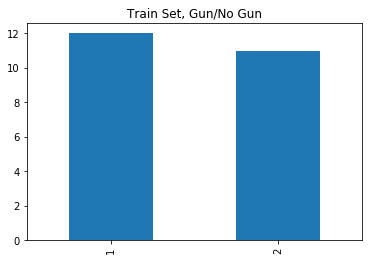

In [7]:
y.value_counts().plot(kind='bar',title='Train Set, Gun/No Gun')

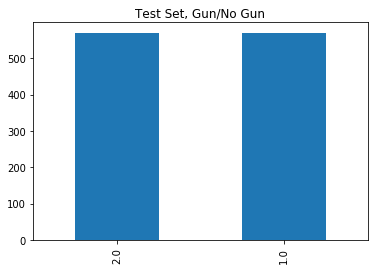

In [8]:
labels.value_counts().plot(kind='bar',title='Test Set, Gun/No Gun')

#### Infrequent Shapelets

In [9]:
start_time = time.process_time()
sp = ShapeletClassifier(min_len=14,max_len=16,normalize=True,n_threads=1000,shapelet_count=100,infreq_shapelets=True,infreq_support=0.05,similarity_threshold=1,fast_shapelets=True,verbose=True,logical_shapelets=False)
sp.fit(X,y)
end_time = time.process_time()
exec_time['Infrequent Shapelets Gun Training Time'] = end_time-start_time

 Fetching Shapelets to represent the target class: 1


[========================================================================] 100%


 Fetching Shapelets to represent the target class: 2


[========================================================================] 100%


In [10]:
predicted = sp.predict(time_series,classifier="d_tree")
exec_acc['Infrequent Shapelets Gun']=accuracy_score(predicted,labels)
predicted = sp.predict(time_series,classifier="dtree")
exec_acc['Infrequent Shapelets Gun dtree']=accuracy_score(predicted,labels)
predicted = sp.predict(time_series,classifier="knn")
exec_acc['Infrequent Shapelets Gun knn']=accuracy_score(predicted,labels)
exec_acc

{'Infrequent Shapelets Gun': 0.8560140474100087,
 'Infrequent Shapelets Gun dtree': 0.9288849868305531,
 'Infrequent Shapelets Gun knn': 0.8525021949078139}

#### Fast Shapelets

In [11]:
start_time = time.process_time()
sp = ShapeletClassifier(min_len=14,max_len=16,normalize=True,n_threads=1000,shapelet_count=10,prune_shapelets=False,fast_shapelets=True,verbose=True,logical_shapelets=False)
sp.fit(X,y)
end_time = time.process_time()
exec_time['Fast Shapelets Gun Training Time'] = end_time-start_time

 Fetching Shapelets to represent the target class: 1


[========================================================================] 100%


 Fetching Shapelets to represent the target class: 2


[========================================================================] 100%


FOR CLASS  1
Information Gain: 0.4530006976752018
Distance: 1.4330547154064914


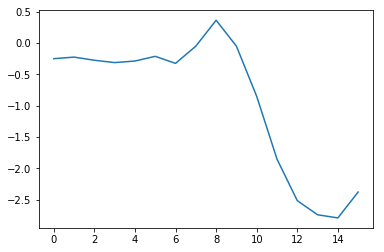

Information Gain: 0.4342685732304794
Distance: 0.9868279836396017


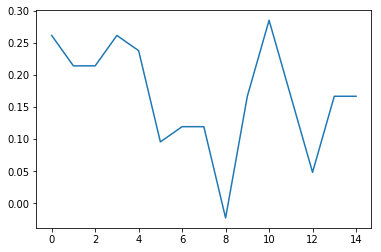

Information Gain: 0.3526499720644378
Distance: 1.8352686375524978


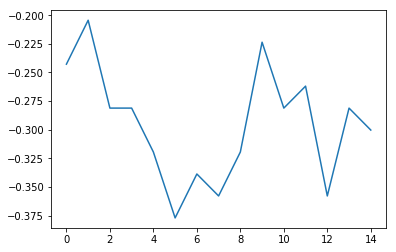

Information Gain: 0.2799696592463625
Distance: 2.042379694556471


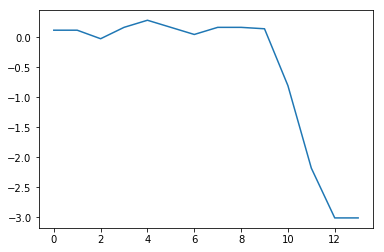

Information Gain: 0.2639348043883857
Distance: 0.9657928556075432


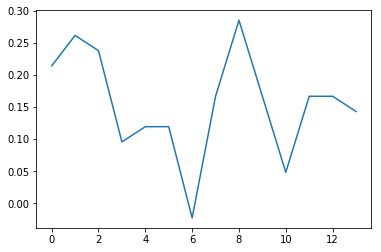

Information Gain: 0.21430603840330997
Distance: 2.6851410924756416


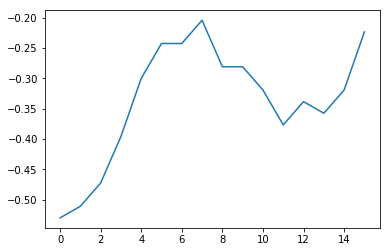

Information Gain: 0.1543310994153816
Distance: 0.8900271667641702


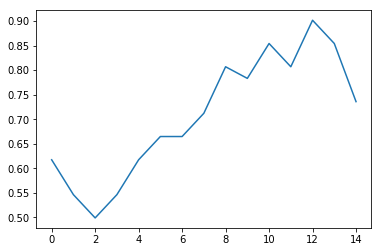

Information Gain: 0.09907983995338554
Distance: 0.5843241499114995


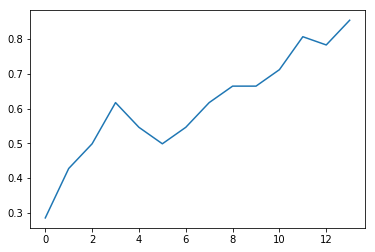

Information Gain: 0.0870865239642209
Distance: 3.5631450195121728


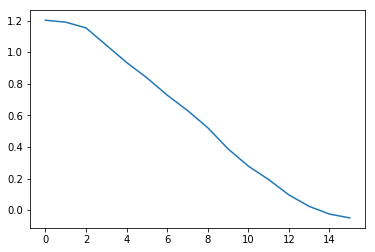

FOR CLASS  2
Information Gain: 0.5278132935798572
Distance: 1.7010610585671615


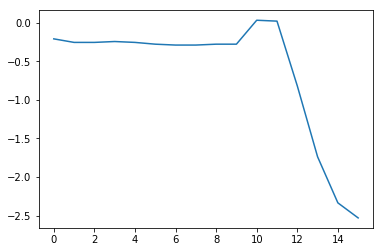

Information Gain: 0.3526499720644378
Distance: 2.197052524037658


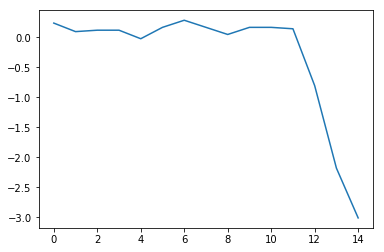

Information Gain: 0.2799696592463625
Distance: 2.042379694556471


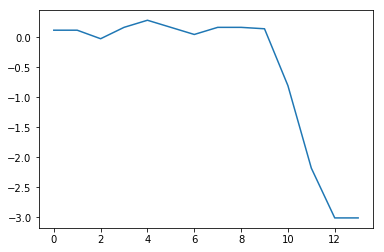

Information Gain: 0.21430603840330997
Distance: 0.6514631706957064


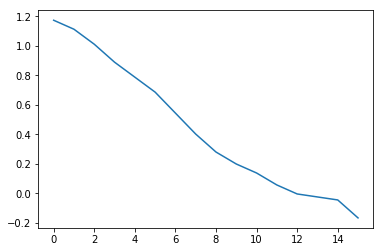

Information Gain: 0.1874674880534476
Distance: 1.0296046619366244


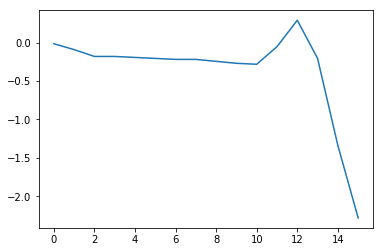

Information Gain: 0.1543310994153816
Distance: 0.5932338750130246


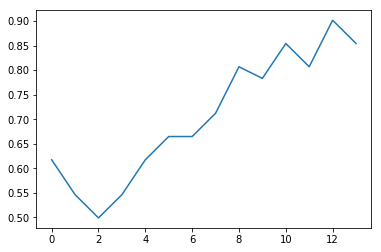

Information Gain: 0.09907983995338554
Distance: 3.087869380413475


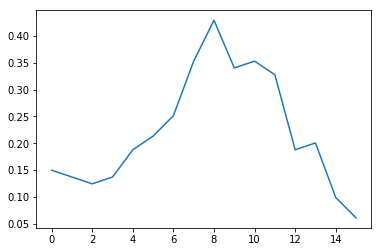

Information Gain: 0.0870865239642209
Distance: 3.5631450195121728


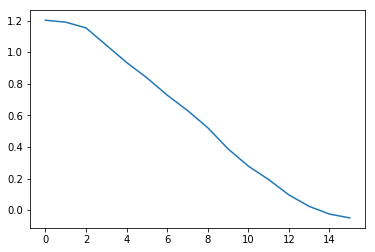

In [12]:
sp.visualise_shapelets(20)

Test Set

In [13]:
predicted = sp.predict(time_series,classifier="d_tree")
exec_acc['Fast Shapelets Gun']=accuracy_score(predicted,labels)
predicted = sp.predict(time_series,classifier="dtree")
exec_acc['Fast Shapelets Gun dtree']=accuracy_score(predicted,labels)
predicted = sp.predict(time_series,classifier="knn")
exec_acc['Fast Shapelets Gun knn']=accuracy_score(predicted,labels)

In [14]:
exec_acc

{'Infrequent Shapelets Gun': 0.8560140474100087,
 'Infrequent Shapelets Gun dtree': 0.9288849868305531,
 'Infrequent Shapelets Gun knn': 0.8525021949078139,
 'Fast Shapelets Gun': 0.7322212467076383,
 'Fast Shapelets Gun dtree': 0.8191395961369623,
 'Fast Shapelets Gun knn': 0.7594381035996488}

#### Brute Force (Pruned)

In [15]:
start_time = time.process_time()
sp = ShapeletClassifier(min_len=14,max_len=16,normalize=True,n_threads=1000,shapelet_count=100,prune_shapelets=True,similarity_threshold=0.1,fast_shapelets=False,verbose=True,logical_shapelets=False)
sp.fit(X,y)
end_time = time.process_time()
exec_time['Pruned Shapelets Gun Training Time'] = end_time-start_time

 Fetching Shapelets to represent the target class: 1


[========================================================================] 100%


 Fetching Shapelets to represent the target class: 2


[========================================================================] 100%


FOR CLASS  1
Information Gain: 0.9986359641585718
Distance: 2.116267098221671


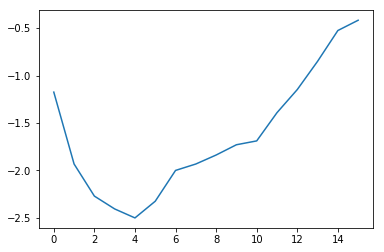

Information Gain: 0.7827315205218933
Distance: 1.4507460787660895


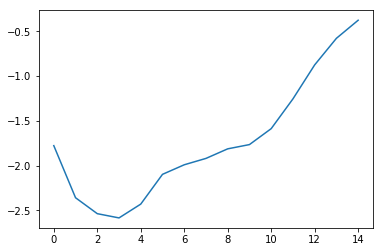

Information Gain: 0.7774982977594274
Distance: 1.7500046288984916


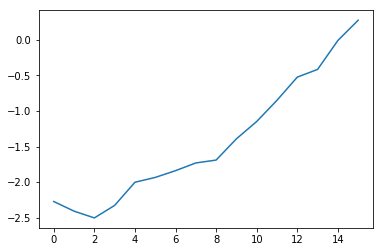

Information Gain: 0.6485503758618792
Distance: 2.1335129802800243


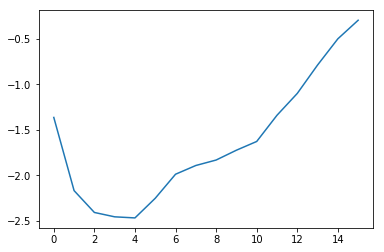

Information Gain: 0.6384873163258508
Distance: 2.3981312679057143


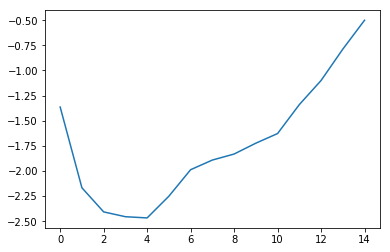

Information Gain: 0.5725373093855174
Distance: 2.1924766209251523


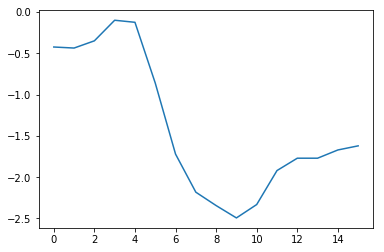

Information Gain: 0.5423605901745405
Distance: 1.7860703689418553


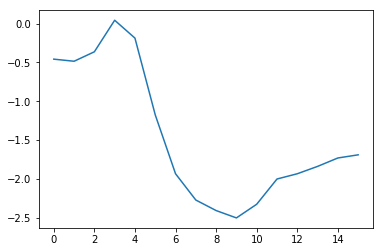

Information Gain: 0.5278132935798572
Distance: 2.4744528010992997


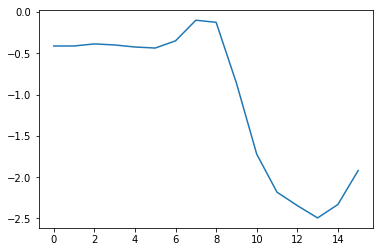

Information Gain: 0.4530006976752018
Distance: 2.485013024366236


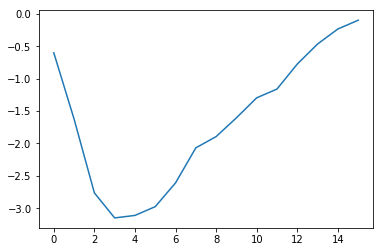

Information Gain: 0.44929961998827195
Distance: 1.830298826728721


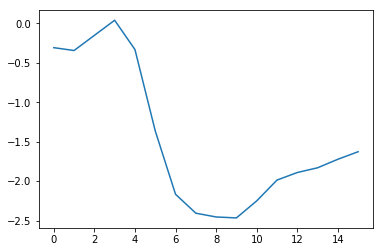

FOR CLASS  2
Information Gain: 0.9986359641585718
Distance: 2.116267098221671


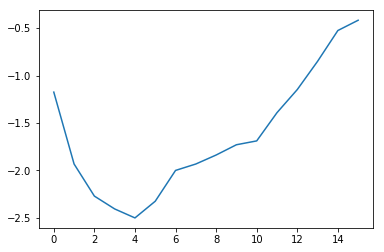

Information Gain: 0.7827315205218933
Distance: 1.4507460787660895


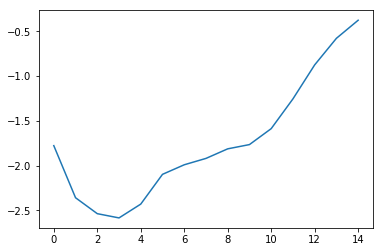

Information Gain: 0.7774982977594274
Distance: 1.7500046288984916


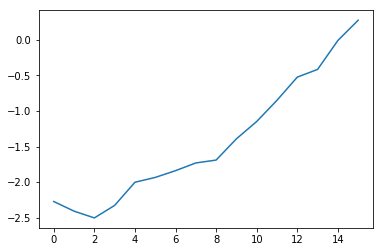

Information Gain: 0.6485503758618792
Distance: 2.1335129802800243


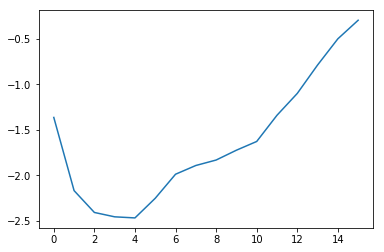

Information Gain: 0.6384873163258508
Distance: 2.3981312679057143


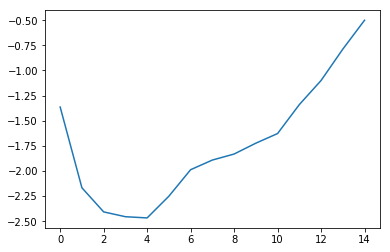

Information Gain: 0.5725373093855174
Distance: 2.1924766209251523


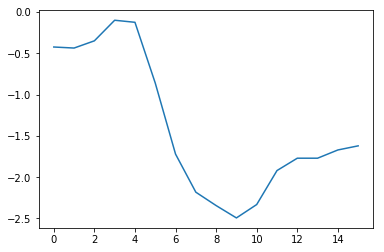

Information Gain: 0.5423605901745405
Distance: 1.7860703689418553


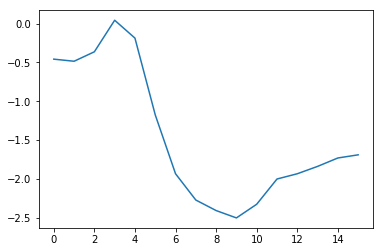

Information Gain: 0.5278132935798572
Distance: 2.4744528010992997


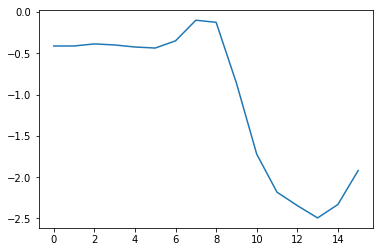

Information Gain: 0.4530006976752018
Distance: 2.485013024366236


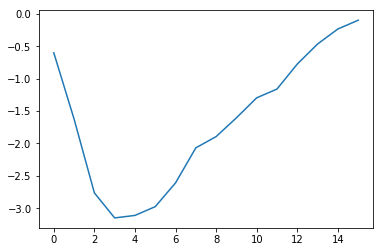

Information Gain: 0.44929961998827195
Distance: 1.830298826728721


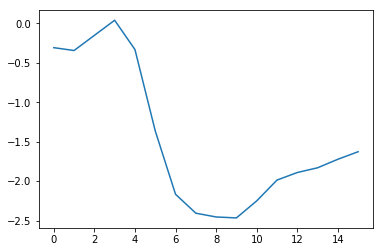

In [16]:
sp.visualise_shapelets()

In [17]:
predicted = sp.predict(time_series,classifier="d_tree")
exec_acc['Pruned Shapelets Gun']=accuracy_score(predicted,labels)
predicted = sp.predict(time_series,classifier="dtree")
exec_acc['Pruned Shapelets Gun dtree']=accuracy_score(predicted,labels)
predicted = sp.predict(time_series,classifier="knn")
exec_acc['Pruned Shapelets Gun knn']=accuracy_score(predicted,labels)

In [18]:
exec_acc

{'Infrequent Shapelets Gun': 0.8560140474100087,
 'Infrequent Shapelets Gun dtree': 0.9288849868305531,
 'Infrequent Shapelets Gun knn': 0.8525021949078139,
 'Fast Shapelets Gun': 0.7322212467076383,
 'Fast Shapelets Gun dtree': 0.8191395961369623,
 'Fast Shapelets Gun knn': 0.7594381035996488,
 'Pruned Shapelets Gun': 0.9341527655838455,
 'Pruned Shapelets Gun dtree': 0.9139596136962248,
 'Pruned Shapelets Gun knn': 0.8217734855136084}

#### Logical Shapelets

In [19]:
start_time = time.process_time()
sp = ShapeletClassifier(min_len=14,max_len=16,normalize=True,n_threads=1000,shapelet_count=100,prune_shapelets=False,fast_shapelets=False,verbose=True,logical_shapelets=True)
sp.fit(X,y)
end_time = time.process_time()
exec_time['Logical Shapelets Gun Training Time'] = end_time-start_time

 Fetching Shapelets to represent the target class: 1


[========================================================================] 100%


Fetch Logical Shapelets


[========================================================================] 100%


 Fetching Shapelets to represent the target class: 2


[========================================================================] 100%


Fetch Logical Shapelets


[========================================================================] 100%


FOR CLASS  1
Information Gain: 0.9986359641585718
Operation: or
Distance: 1.6915501946298117
Information Gain: 0.7827315205218933
Operation: or
Distance: 1.5823955849568754
Information Gain: 0.7774982977594274
Operation: single
Distance: 2.0618117511962937


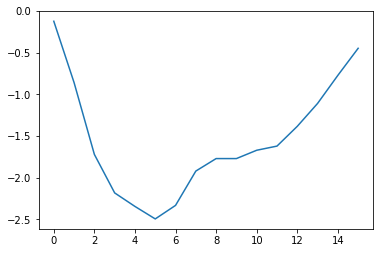

Information Gain: 0.6485503758618792
Operation: and
Distance: 1.7109748326625314
Information Gain: 0.6384873163258508
Operation: and
Distance: 2.3078711992671654
Information Gain: 0.5725373093855174
Operation: and
Distance: 2.1909897139971637
Information Gain: 0.5423605901745405
Operation: and
Distance: 1.9203181965233898
Information Gain: 0.5278132935798572
Operation: single
Distance: 2.4447489051200715


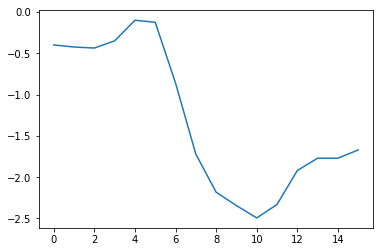

FOR CLASS  2
Information Gain: 0.9986359641585718
Operation: single
Distance: 2.2128200711202846


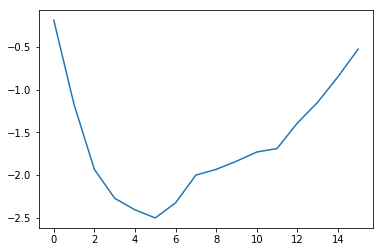

Information Gain: 0.7827315205218933
Operation: and
Distance: 2.202121818855712
Information Gain: 0.7774982977594274
Operation: or
Distance: 2.2128200711202846
Information Gain: 0.6485503758618792
Operation: and
Distance: 2.038482383267378
Information Gain: 0.6384873163258508
Operation: single
Distance: 2.4019931445724065


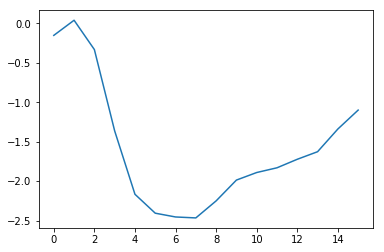

In [20]:
sp.visualise_shapelets(20)

In [21]:
predicted = sp.predict(time_series,classifier="d_tree")
exec_acc['Logical Shapelets Gun']=accuracy_score(predicted,labels)
predicted = sp.predict(time_series,classifier="dtree")
exec_acc['Logical Shapelets Gun dtree']=accuracy_score(predicted,labels)
predicted = sp.predict(time_series,classifier="knn")
exec_acc['Logical Shapelets Gun knn']=accuracy_score(predicted,labels)

Test Set

In [22]:
exec_acc

{'Infrequent Shapelets Gun': 0.8560140474100087,
 'Infrequent Shapelets Gun dtree': 0.9288849868305531,
 'Infrequent Shapelets Gun knn': 0.8525021949078139,
 'Fast Shapelets Gun': 0.7322212467076383,
 'Fast Shapelets Gun dtree': 0.8191395961369623,
 'Fast Shapelets Gun knn': 0.7594381035996488,
 'Pruned Shapelets Gun': 0.9341527655838455,
 'Pruned Shapelets Gun dtree': 0.9139596136962248,
 'Pruned Shapelets Gun knn': 0.8217734855136084,
 'Logical Shapelets Gun': 0.8366988586479368,
 'Logical Shapelets Gun dtree': 0.9086918349429324,
 'Logical Shapelets Gun knn': 0.8560140474100087}

#### Brute Force

In [23]:
start_time = time.process_time()
sp = ShapeletClassifier(min_len=14,max_len=16,n_threads=3000,normalize=True,shapelet_count=100,prune_shapelets=False,fast_shapelets=False,verbose=True)
sp.fit(X,y)
end_time = time.process_time()
exec_time['Brute Force Gun Training Time'] = end_time-start_time

 Fetching Shapelets to represent the target class: 1


[========================================================================] 100%


 Fetching Shapelets to represent the target class: 2


[========================================================================] 100%


FOR CLASS  1
Information Gain: 0.9986359641585718
Distance: 2.116267098221671


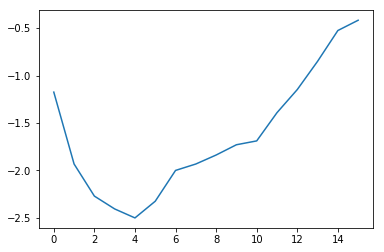

Information Gain: 0.7827315205218933
Distance: 1.4507460787660895


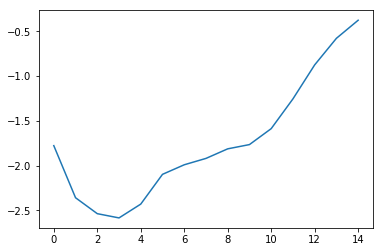

Information Gain: 0.7774982977594274
Distance: 1.7500046288984916


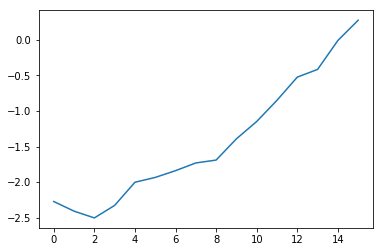

Information Gain: 0.6485503758618792
Distance: 2.1335129802800243


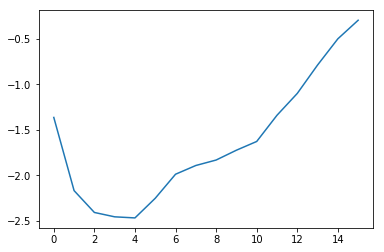

Information Gain: 0.6384873163258508
Distance: 2.3981312679057143


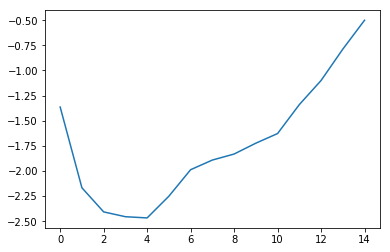

Information Gain: 0.5725373093855174
Distance: 2.1924766209251523


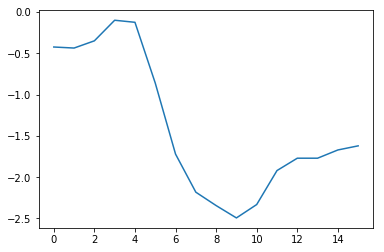

Information Gain: 0.5423605901745405
Distance: 1.7860703689418553


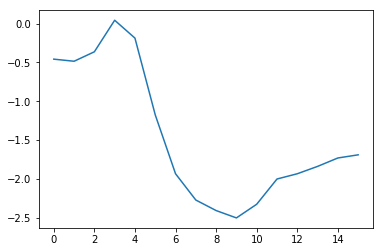

Information Gain: 0.5278132935798572
Distance: 2.4744528010992997


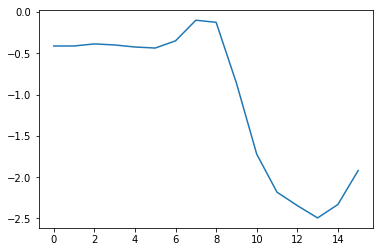

Information Gain: 0.4530006976752018
Distance: 2.485013024366236


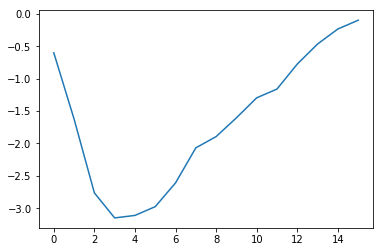

Information Gain: 0.44929961998827195
Distance: 1.830298826728721


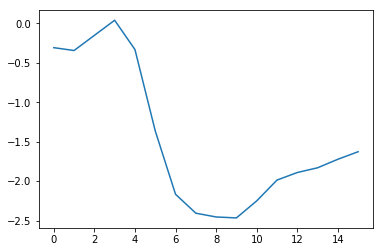

FOR CLASS  2
Information Gain: 0.9986359641585718
Distance: 2.116267098221671


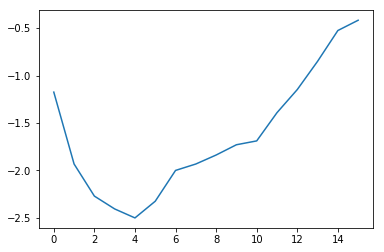

Information Gain: 0.7827315205218933
Distance: 1.4507460787660895


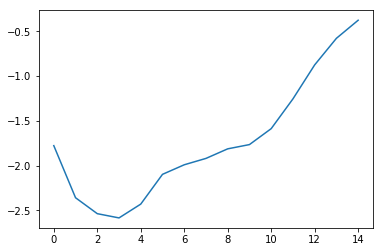

Information Gain: 0.7774982977594274
Distance: 1.7500046288984916


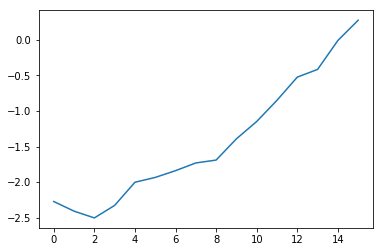

Information Gain: 0.6485503758618792
Distance: 2.1335129802800243


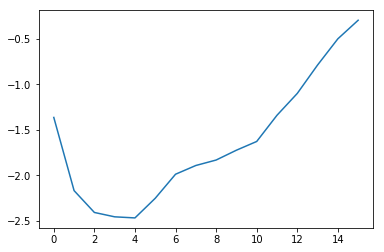

Information Gain: 0.6384873163258508
Distance: 2.3981312679057143


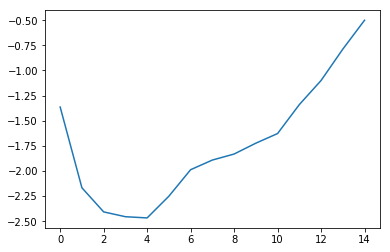

Information Gain: 0.5725373093855174
Distance: 2.1924766209251523


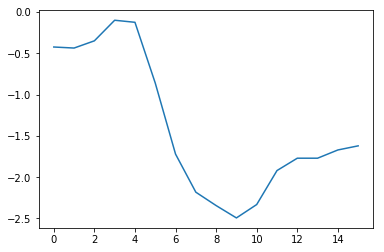

Information Gain: 0.5423605901745405
Distance: 1.7860703689418553


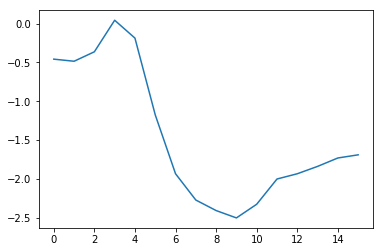

Information Gain: 0.5278132935798572
Distance: 2.4744528010992997


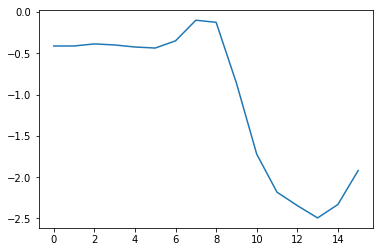

Information Gain: 0.4530006976752018
Distance: 2.485013024366236


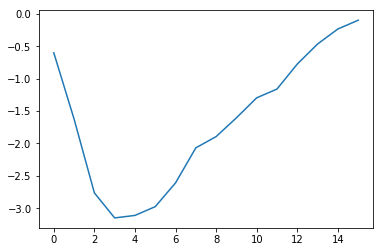

Information Gain: 0.44929961998827195
Distance: 1.830298826728721


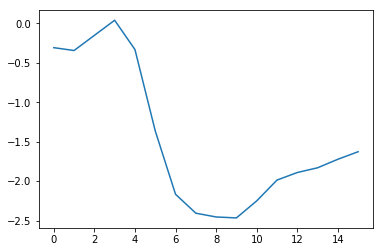

In [24]:
sp.visualise_shapelets()

In [25]:
predicted = sp.predict(time_series,classifier="d_tree")
exec_acc['Brute Force Shapelets Gun']=accuracy_score(predicted,labels)
predicted = sp.predict(time_series,classifier="dtree")
exec_acc['Brute Force Shapelets Gun dtree']=accuracy_score(predicted,labels)
predicted = sp.predict(time_series,classifier="knn")
exec_acc['Brute Force Shapelets Gun knn']=accuracy_score(predicted,labels)

In [26]:
exec_acc

{'Infrequent Shapelets Gun': 0.8560140474100087,
 'Infrequent Shapelets Gun dtree': 0.9288849868305531,
 'Infrequent Shapelets Gun knn': 0.8525021949078139,
 'Fast Shapelets Gun': 0.7322212467076383,
 'Fast Shapelets Gun dtree': 0.8191395961369623,
 'Fast Shapelets Gun knn': 0.7594381035996488,
 'Pruned Shapelets Gun': 0.9341527655838455,
 'Pruned Shapelets Gun dtree': 0.9139596136962248,
 'Pruned Shapelets Gun knn': 0.8217734855136084,
 'Logical Shapelets Gun': 0.8366988586479368,
 'Logical Shapelets Gun dtree': 0.9086918349429324,
 'Logical Shapelets Gun knn': 0.8560140474100087,
 'Brute Force Shapelets Gun': 0.9341527655838455,
 'Brute Force Shapelets Gun dtree': 0.9139596136962248,
 'Brute Force Shapelets Gun knn': 0.8217734855136084}

#### LFDPS Optimization

In [59]:
print(len(X[0]))

82


In [80]:
start_time = time.process_time()
sp = ShapeletClassifier(min_len=14,max_len=26,normalize=True,n_threads=1000,shapelet_count=10,prune_shapelets=False,fast_shapelets=False,verbose=True,logical_shapelets=True, lfdps=True)
sp.fit(X,y)
end_time = time.process_time()
exec_time['Fast LFPDs Shapelets Gun Training Time'] = end_time-start_time

 Fetching Shapelets to represent the target class: 1


[========================================================================] 100%


Fetch Logical Shapelets


[========================================================================] 100%


 Fetching Shapelets to represent the target class: 2


[========================================================================] 100%


Fetch Logical Shapelets


[========================================================================] 100%


FOR CLASS  1
Information Gain: 0.7827315205218933
Operation: single
Distance: 7.564310438488501


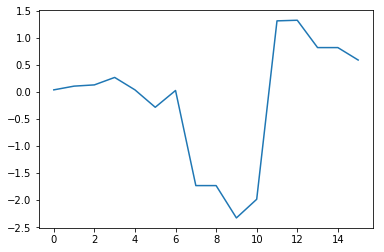

Information Gain: 0.6485503758618792
Operation: single
Distance: 7.629655685597247


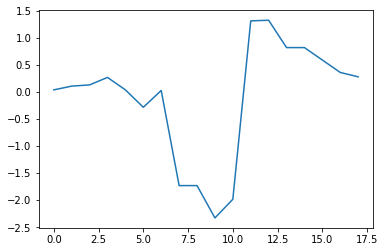

Information Gain: 0.5725373093855174
Operation: or
Distance: 7.564310438488501


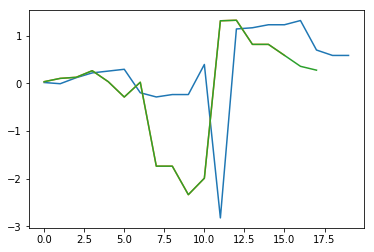

Information Gain: 0.5423605901745405
Operation: or
Distance: 5.050601682236591


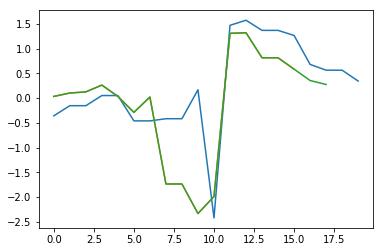

Information Gain: 0.4530006976752018
Operation: single
Distance: 7.504996544021148


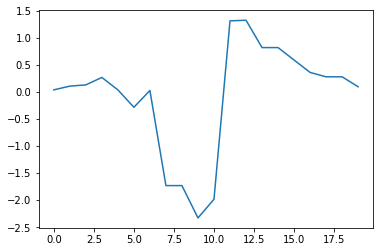

Information Gain: 0.44929961998827195
Operation: single
Distance: 6.941864141818441


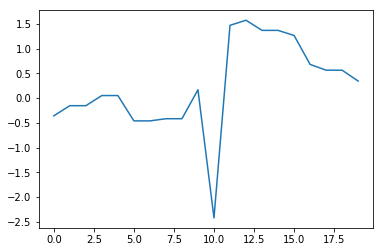

FOR CLASS  2
Information Gain: 0.7827315205218933
Operation: single
Distance: 7.564310438488501


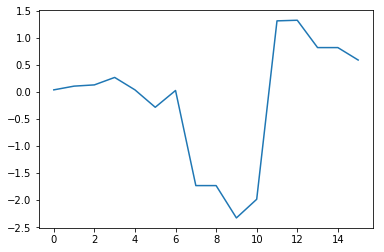

Information Gain: 0.7774982977594274
Operation: or
Distance: 7.564310438488501


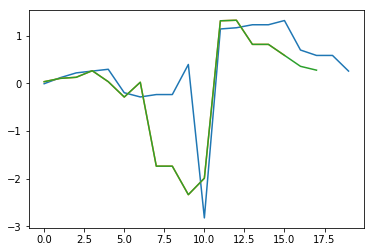

Information Gain: 0.6485503758618792
Operation: single
Distance: 7.629655685597247


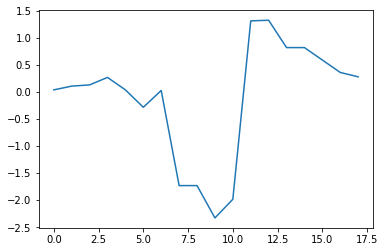

Information Gain: 0.5725373093855174
Operation: or
Distance: 7.564310438488501


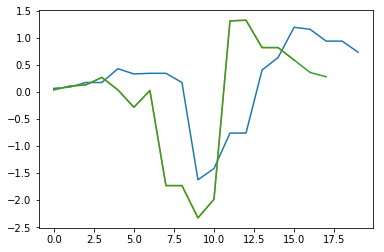

Information Gain: 0.5423605901745405
Operation: single
Distance: 6.544980827149816


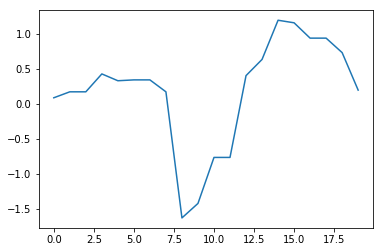

Information Gain: 0.4530006976752018
Operation: single
Distance: 7.504996544021148


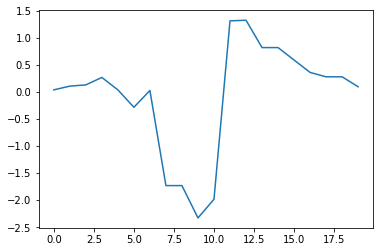

In [77]:
sp.visualise_shapelets()

In [78]:
predicted = sp.predict(time_series,classifier="d_tree")
exec_acc['Fast LFPDs Shapelets Gun']=accuracy_score(predicted,labels)
predicted = sp.predict(time_series,classifier="dtree")
exec_acc['Fast LFPDs Shapelets Gun dtree']=accuracy_score(predicted,labels)
predicted = sp.predict(time_series,classifier="knn")
exec_acc['Fast LFPDs Shapelets Gun knn']=accuracy_score(predicted,labels)

In [81]:
exec_acc

{'Infrequent Shapelets Gun': 0.8560140474100087,
 'Infrequent Shapelets Gun dtree': 0.9288849868305531,
 'Infrequent Shapelets Gun knn': 0.8525021949078139,
 'Fast Shapelets Gun': 0.7322212467076383,
 'Fast Shapelets Gun dtree': 0.8191395961369623,
 'Fast Shapelets Gun knn': 0.7594381035996488,
 'Pruned Shapelets Gun': 0.9341527655838455,
 'Pruned Shapelets Gun dtree': 0.9139596136962248,
 'Pruned Shapelets Gun knn': 0.8217734855136084,
 'Logical Shapelets Gun': 0.8366988586479368,
 'Logical Shapelets Gun dtree': 0.9086918349429324,
 'Logical Shapelets Gun knn': 0.8560140474100087,
 'Brute Force Shapelets Gun': 0.9341527655838455,
 'Brute Force Shapelets Gun dtree': 0.9139596136962248,
 'Brute Force Shapelets Gun knn': 0.8217734855136084,
 'Fast LFPDs Shapelets Gun': 0.5004389815627743,
 'Fast LFPDs Shapelets Gun dtree': 0.8647936786654961,
 'Fast LFPDs Shapelets Gun knn': 0.9051799824407375}

In [47]:
def getColors(length):
    colors = list()
    for i in range(length):
        colors.append(list(np.random.rand(3,)))
    return colors

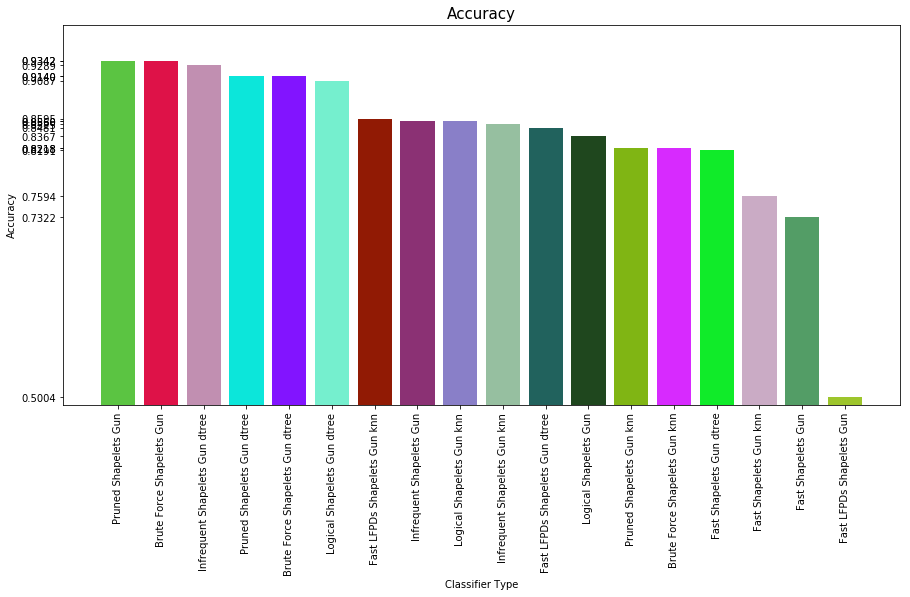

In [57]:
plot_graph(exec_acc,"Accuracy")

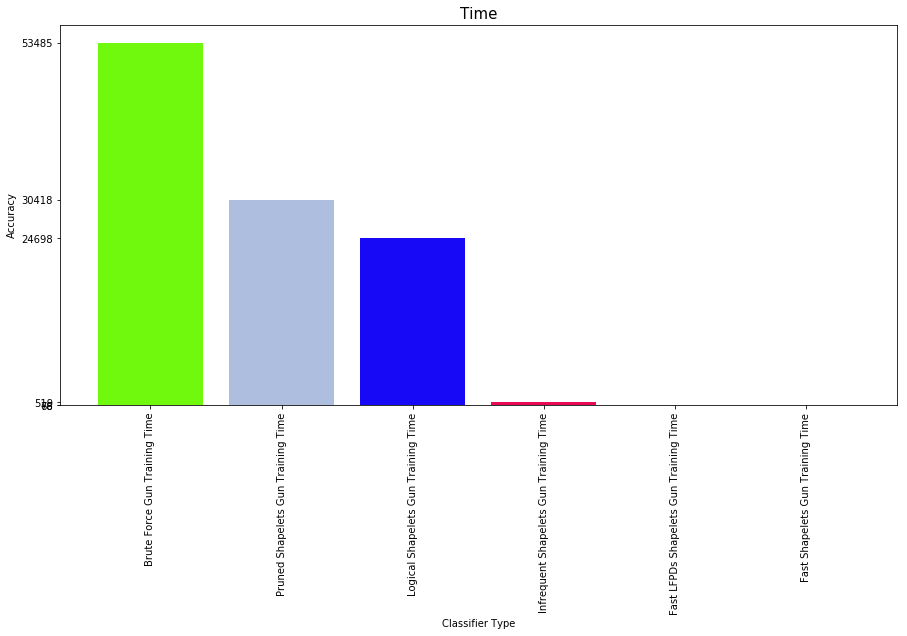

In [58]:
plot_graph(exec_time,"Time")